In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [2]:
## Load dataset
data_path = "../../../Rings_2D"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()

NUM_DATASETS, N, D = OB.shape

SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))
NUM_EPOCHS = 500
NUM_HIDDEN = 32
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')

RADI = torch.ones(1) * 2.0
NOISE_SIGMA = torch.ones(1) * 0.1
lg2pi = torch.ones(1) * 2 * math.pi
if CUDA:
    RADI = RADI.cuda().to(DEVICE)
    NOISE_SIGMA = NOISE_SIGMA.cuda().to(DEVICE)
    lg2pi = lg2pi.cuda().to(DEVICE)

In [3]:
from local_enc_angle import *
enc_angle = Enc_angle(D, NUM_HIDDEN, CUDA, DEVICE)
if CUDA:
    enc_angle.cuda().to(DEVICE)
optimizer_phi =  torch.optim.Adam(list(enc_angle.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [7]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    LOSS_phi = 0.0
    ELBO = 0.0
    EUBO = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer_phi.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        state = STATE[batch_indices]
        mu = MU[batch_indices]
        mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
        shuffled = shuffler(torch.cat((ob, state), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
        
        if CUDA:
            shuffled = shuffled.cuda().to(DEVICE)
            mu = mu.cuda().to(DEVICE)
        ob = shuffled[:, :, :, :2]
        state = shuffled[:, :, :, 2:]
        q, p = enc_angle(ob, state, mu)
        angle = p['angles'].value
        ll = ll_angle(ob, state, angle, mu, RADI, NOISE_SIGMA, cluster_flag=False)
        log_w = p['angles'].log_prob.sum(-1) - (q['angles'].log_prob.sum(-1) - lg2pi) + ll
        w = torch.softmax(log_w, 0).detach()
        loss_phi = (w * (- q['angles'].log_prob.sum(-1) + lg2pi)).sum(0).sum(-1).mean()
        elbo = log_w.sum(-1).mean()
        eubo = (w * log_w).sum(0).sum(-1).mean()
        loss_phi.backward()
        optimizer_phi.step()
        LOSS_phi += loss_phi
        ELBO += elbo
        EUBO += eubo
    time_end = time.time()
    print('epoch=%d, eubo=%.4f, elbo=%.4f, loss_phi=%.4f (%ds)' % (epoch,  EUBO / NUM_BATCHES, ELBO / NUM_BATCHES, LOSS_phi / NUM_BATCHES, time_end - time_start))

epoch=0, eubo=774.4755, elbo=-32.8989, loss_phi=870.9391 (0s)
epoch=1, eubo=775.0614, elbo=-33.6794, loss_phi=870.9589 (0s)
epoch=2, eubo=775.7380, elbo=-27.5444, loss_phi=870.8556 (0s)
epoch=3, eubo=771.3459, elbo=-30.2763, loss_phi=870.8600 (0s)
epoch=4, eubo=773.7724, elbo=-29.4250, loss_phi=870.9339 (0s)
epoch=5, eubo=774.0134, elbo=-26.0934, loss_phi=870.8480 (0s)
epoch=6, eubo=777.8059, elbo=-20.8648, loss_phi=870.6457 (0s)
epoch=7, eubo=775.0104, elbo=-24.0966, loss_phi=870.9311 (0s)
epoch=8, eubo=777.2950, elbo=-21.8452, loss_phi=870.8007 (0s)
epoch=9, eubo=775.6492, elbo=-21.8419, loss_phi=870.8050 (0s)
epoch=10, eubo=776.4727, elbo=-18.0038, loss_phi=870.6094 (0s)
epoch=11, eubo=771.3694, elbo=-21.6452, loss_phi=870.6762 (0s)
epoch=12, eubo=774.1258, elbo=-16.3797, loss_phi=870.6527 (0s)
epoch=13, eubo=777.2363, elbo=-17.4023, loss_phi=870.4777 (0s)
epoch=14, eubo=776.9479, elbo=-17.9597, loss_phi=870.6480 (0s)
epoch=15, eubo=776.8890, elbo=-17.7020, loss_phi=870.6547 (0s)
ep

In [8]:
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
ob = OB[batch_indices]
state = STATE[batch_indices]
mu = MU[batch_indices]
angle_true = ANGLE[batch_indices]
mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)

shuffled = shuffler(torch.cat((ob, state, angle_true), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    shuffled = shuffled.cuda().to(DEVICE)
    mu = mu.cuda().to(DEVICE)
ob = shuffled[:, :, :, :2]
state = shuffled[:, :, :, 2:-1]
angle_true = shuffled[:,:,:,-1]
q, p = enc_angle(ob, state, mu)
angle = p['angles'].value


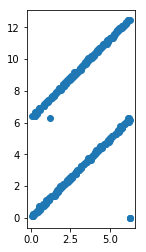

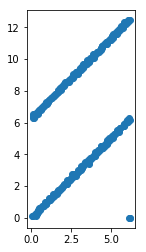

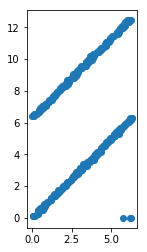

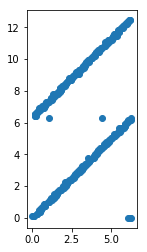

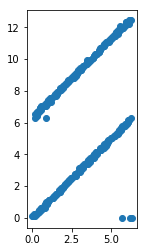

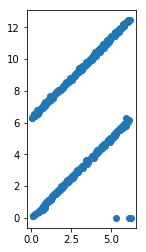

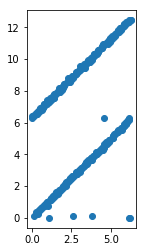

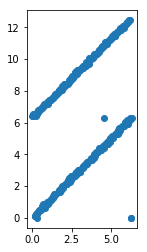

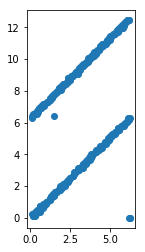

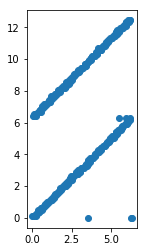

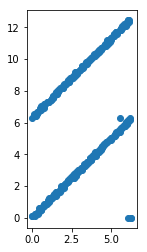

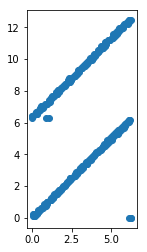

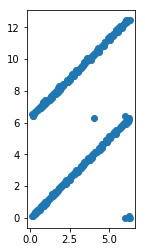

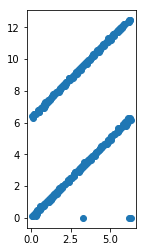

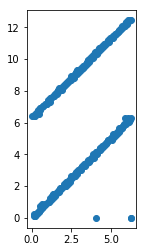

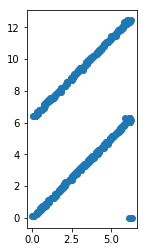

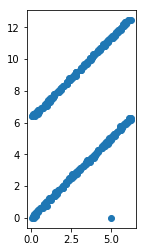

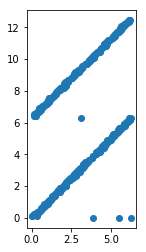

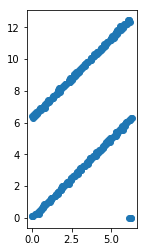

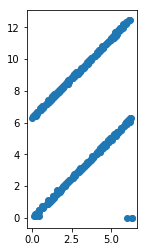

In [9]:
for i in range(BATCH_SIZE):
    angle_b_inferred = angle[0, i, :, 0].cpu().data.numpy()
    angle_b_true = angle_true[0, i].cpu().data.numpy()
    plt.scatter(angle_b_inferred, angle_b_true)
    plt.gca().set_aspect('equal')
    plt.show()
    

In [ ]:
angle_true.shape

In [ ]:
N